In [1]:
import os
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold

import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm_notebook
from sklearn.tree import export_graphviz
import lightgbm as lgb
%matplotlib inline

In [2]:
train_df = pd.read_csv(os.path.join("input",'train.csv'), dtype={'acoustic_data': np.int16, 'time_to_failure': np.float32})

In [3]:
train_df.shape

(629145480, 2)

In [4]:
rows = 150000
segments = int(np.floor(train_df.shape[0] / rows))
print("Number of segments: ", segments)

Number of segments:  4194


In [5]:
train_X = pd.DataFrame(index=range(segments), dtype=np.float64)
train_y = pd.DataFrame(index=range(segments), dtype=np.float64, columns=['time_to_failure'])

In [6]:
def create_features(seg_id,seg, X):
    xc = seg["acoustic_data"]

    X.loc[seg_id,"avg"] = xc.mean()
    X.loc[seg_id,"max"] = xc.max()
    X.loc[seg_id,"min"] = xc.min()
    X.loc[seg_id,"skew"] = xc.skew()
    X.loc[seg_id,"kurt"] = xc.kurt()
    X.loc[seg_id,"median"] = xc.median()
    X.loc[seg_id,"var"] = xc.var()
    
    window_sizes = [20,50,100,300,1000]
    for window_size in window_sizes:
        xc_rolled_mean = xc.rolling(window_size).mean()
        ws = str(window_size)
        X.loc[seg_id,"rolling_mean_"+ws] = xc_rolled_mean.mean()
        X.loc[seg_id,"rolling_max_"+ ws] = xc_rolled_mean.max()
        X.loc[seg_id,"rolling_min_"+ws] = xc_rolled_mean.min()
        X.loc[seg_id,"rolling_skew_"+ws] = xc_rolled_mean.skew()
        X.loc[seg_id,"rolling_kurt_"+ws] = xc_rolled_mean.kurt()
        X.loc[seg_id,"rolling_var_"+ws] = xc_rolled_mean.var()

In [7]:
for seg_id in tqdm_notebook(range(segments)):
    seg = train_df.iloc[seg_id*rows:seg_id*rows+rows]
    create_features(seg_id, seg,train_X)
    train_y.loc[seg_id, 'time_to_failure'] = seg['time_to_failure'].values[-1]

In [8]:
def load_test():
    signals = []
    segment_names = [file for file in os.listdir("./input") if file.startswith("seg")]
    test_df = pd.DataFrame(index=segment_names, dtype=np.float64)
    test_df.index = test_df.index.str[:-4]
    for file in tqdm_notebook(segment_names):
        seg_id = file[:-4]
        segment = pd.read_csv(os.path.join("input",file),dtype={'acoustic_data': np.int16})
        create_features(seg_id,segment,test_df)
    return test_df
test_df = load_test()

In [9]:
train_X.head()

,avg,max,min,skew,kurt,median,var,rolling_mean_20,rolling_max_20,rolling_min_20,...,rolling_min_300,rolling_skew_300,rolling_kurt_300,rolling_var_300,rolling_mean_1000,rolling_max_1000,rolling_min_1000,rolling_skew_1000,rolling_kurt_1000,rolling_var_1000
0,4.884113,104.0,-98.0,-0.024061,33.662481,5.0,26.021284,4.884074,27.45,-13.95,...,3.643333,-0.216399,0.020864,0.117756,4.883418,5.629,3.896,-0.362100,-0.011405,0.087448
1,4.725767,181.0,-154.0,0.390561,98.758517,5.0,43.412599,4.725761,83.85,-78.95,...,1.623333,-0.092537,2.267533,0.091278,4.724876,5.667,3.412,-0.037063,-0.401352,0.053633
2,4.906393,140.0,-106.0,0.217391,33.555211,5.0,48.544621,4.906117,51.95,-36.55,...,2.413333,0.050486,1.195594,0.116096,4.905840,5.957,4.055,-0.151766,0.025022,0.071296
3,4.902240,197.0,-199.0,0.757278,116.548172,5.0,47.918309,4.902149,78.15,-88.95,...,1.620000,-0.227936,3.178413,0.117735,4.901486,5.858,3.722,-0.205127,-0.505194,0.071129
4,4.908720,145.0,-126.0,0.064531,52.977905,5.0,53.306210,4.908875,58.90,-42.75,...,2.636667,0.588707,4.599418,0.104880,4.910196,6.078,3.918,0.233304,0.195879,0.051987


In [10]:
test_df.head()

,avg,max,min,skew,kurt,median,var,rolling_mean_20,rolling_max_20,rolling_min_20,...,rolling_min_300,rolling_skew_300,rolling_kurt_300,rolling_var_300,rolling_mean_1000,rolling_max_1000,rolling_min_1000,rolling_skew_1000,rolling_kurt_1000,rolling_var_1000
seg_00030f,4.491780,115.0,-75.0,0.327908,28.837568,4.0,23.948199,4.491907,45.65,-41.25,...,2.856667,-0.060979,0.422382,0.086757,4.491468,5.495,3.774,-0.161726,0.061229,0.053774
seg_0012b5,4.171153,152.0,-140.0,0.295708,56.218955,4.0,35.080027,4.171250,50.60,-38.85,...,1.930000,0.091128,0.951139,0.090852,4.173633,5.009,3.342,0.010131,-0.085346,0.053321
seg_00184e,4.610260,248.0,-193.0,0.428688,162.118284,5.0,48.260671,4.610268,96.70,-87.75,...,0.436667,0.072951,4.557585,0.101746,4.612455,6.234,3.544,-0.210958,-0.411439,0.061118
seg_003339,4.531473,85.0,-93.0,0.061889,41.241827,5.0,16.926202,4.531435,23.50,-8.65,...,3.513333,0.175770,0.684681,0.078519,4.532571,5.446,3.889,0.179065,-0.116018,0.050584
seg_0042cc,4.128340,177.0,-147.0,0.073898,79.539708,4.0,33.607106,4.128313,42.40,-28.85,...,2.450000,0.212918,0.697991,0.111619,4.125805,5.027,3.357,0.111537,0.098487,0.075090


In [11]:
n_fold = 5
folds = KFold(n_splits=n_fold, shuffle=True, random_state=42)

In [50]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'l2', 'l1'},
    'num_leaves': 50,
    'learning_rate': 0.001,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.85,
    'bagging_freq': 5,
    'verbose': 1,
    'metric':'mae'
}

In [51]:
features_importance = pd.DataFrame({"features":train_X.columns,
                                    "importance":np.zeros(train_X.columns.shape[0])})
predictions = pd.DataFrame({"seg_id":test_df.index,"time_to_failure":np.zeros(test_df.shape[0])})
oof = np.zeros(segments)
for train_idx,val_idx in folds.split(train_X,train_y):
    X_train,y_train = train_X.iloc[train_idx],train_y.iloc[train_idx]
    X_val,y_val = train_X.iloc[val_idx],train_y.iloc[val_idx]
    
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_val,y_val, reference=lgb_train)
#     model = lgb.LGBMRegressor(**params, n_estimators = 20000, n_jobs = -1)
    model = lgb.LGBMRegressor(**params, n_estimators = 20000, n_jobs = -1)
    model.fit(X_train,y_train,
              eval_set=[(X_train,y_train),(X_val,y_val)], 
              verbose=1000,
              early_stopping_rounds=1000)
    
    oof[val_idx] = model.predict(X_val)
    
    features_importance["importance"] += model.feature_importances_
    predictions["time_to_failure"] += model.predict(test_df, num_iteration=model.best_iteration_) 
    
#     print("MAE_val = {}".format(mean_absolute_error(y_val,oof[val_idx])))

Training until validation scores don't improve for 1000 rounds.
[1000]	training's l1: 2.14754	valid_1's l1: 2.38984
[2000]	training's l1: 1.818	valid_1's l1: 2.27477
[3000]	training's l1: 1.62074	valid_1's l1: 2.25233
[4000]	training's l1: 1.46399	valid_1's l1: 2.24478
[5000]	training's l1: 1.333	valid_1's l1: 2.245
Early stopping, best iteration is:
[4267]	training's l1: 1.427	valid_1's l1: 2.24292
Training until validation scores don't improve for 1000 rounds.
[1000]	training's l1: 2.14236	valid_1's l1: 2.39206
[2000]	training's l1: 1.81103	valid_1's l1: 2.28077
[3000]	training's l1: 1.61112	valid_1's l1: 2.25573
[4000]	training's l1: 1.45256	valid_1's l1: 2.25635
Early stopping, best iteration is:
[3450]	training's l1: 1.53568	valid_1's l1: 2.25426
Training until validation scores don't improve for 1000 rounds.
[1000]	training's l1: 2.13448	valid_1's l1: 2.43509
[2000]	training's l1: 1.80705	valid_1's l1: 2.2948
[3000]	training's l1: 1.60637	valid_1's l1: 2.26491
[4000]	training's l

In [52]:
mean_absolute_error(train_y,oof)

2.238030351405061

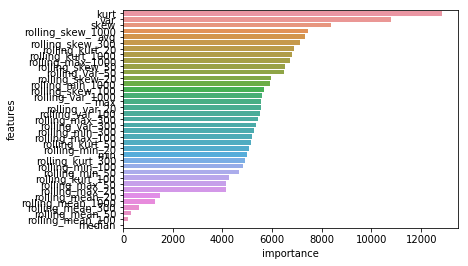

In [53]:
features_importance["importance"] = features_importance["importance"]/5
predictions["time_to_failure"] = predictions["time_to_failure"]/5
sns.barplot(x="importance", y="features", data=features_importance.sort_values(by="importance",ascending=False))

In [54]:
predictions.to_csv("submissions/submission_lgb.csv",index=False)